## General Workflow

### 1) Identifying Business Problem
### 2) Data Preprocessing
### 3) Exploratory Data Analysis (EDA)
### 4) Model Development & Evaluation
### 5) Model Interpretability

### 1) Identifying Business Problem

In this case, we're asked to develop a model for an organization that helps non-profit organizations to find donors. This model will be used to predict whether a donor will spend more than or equal to 30€, given that this donor receives a re-activation campaign. The model will be trained based on the previous campaign, and then validated with another data from other campaign.

The model is expected to have a good performance and high interpretability. In addition, we also have to emphasize why does implementing the model is better than random guessing campaign. In the end, the model will be used to predict potential customers for the upcoming campaign, and which customers are the most effective to reach.

### 2) Data Preprocessing

Our data consist of 5 csv files which includes the donor database, the amount of donated, and the selected donors during previous campaign

In [196]:
import sys
import subprocess
import importlib

packages = ['pandas', 'numpy','pathlib','os','glob', 'textblob']
[subprocess.check_call(['pip', 'install', pkg]) 
for pkg in packages if not importlib.util.find_spec(pkg)]

[]

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
import pathlib
import os
import glob
from numpy import where

from textblob import TextBlob

import datetime

import plotly.express as px


In [2]:
# Change to working dir
os.chdir("Data")

### Load Data

In [ ]:
# Loop through data folder and add all df's in a dict
data_dict={}
for txt_file in glob.glob("*.csv"):
    #list filenames
    filename = txt_file
    #create python tablenames
    df_name = str.replace(str.replace(txt_file,".csv","_raw")," ","_")
    #read files
    df_value = pd.read_csv(filename,  delimiter=",")
    #add to dict
    data_dict[df_name] = df_value

In [ ]:
# Split dict into indivisual dataframes
for var in data_dict.keys():
    exec("{} = data_dict['{}']".format(var, var))

In [ ]:
data_dict.keys()

dict_keys(['campaigns_raw', 'donors_raw', 'gifts_raw', 'selection_campaign_6169_raw', 'selection_campaign_7244_raw'])

### Data exploration

### Donors Data

In [ ]:
# Drop 1st Column
donors = donors_raw
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

campaign6169 = datetime.datetime(2018, 9, 4)

donors['Age'] = donors['dateOfBirth'].apply(lambda row: campaign6169.year - row.year -((campaign6169.month, campaign6169.day) < (row.month, row.day) ))
# Change ANTWERP provinces to Antwerp

donors['province'] = donors['province'].apply(lambda row: 'Antwerp' if row == 'ANTWERP' else row)

donors.head()

,Unnamed: 0,donorID,zipcode,province,region,gender,language,dateOfBirth,Age
0,0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,50
1,1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,66
2,2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23,31
3,3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,66
4,4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25,32


In [ ]:
fig = px.bar(donors, x="gender", y="region", color="province", width=800, height=400, )
fig.show()

### Gifts Data

In [ ]:
# Drop 1st Column
gifts = gifts_raw.iloc[: , 1:]
#cleaning gift
# Change date into datetime object
gifts['date'] = pd.to_datetime(gifts['date'])
#
gifts['amount'] = gifts['amount'].str.replace(',', '.')
#
gifts['amount'] = gifts['amount'].astype('float')
# Assume Independent Variable Period of 6 Months
iv_period = 180
#
in_between_period = 30



### Base Table for the training set

Some info on this table:
- The basis table is the donors that were selected for campaign 6169
- IV period of 6 months, with gap period of 7 days
- DV period is not specified. Donors are selected on the basis of their reaction to the corresponding campaign (only takes into account campaign 6169)
- Granularity is DonorID

In [199]:

#first gift table 6169 campaign
#_______________________________________________
#
selection_campaign_6169=selection_campaign_6169_raw
# Only select rows within our Independent Variable Timeline
gifts_dv_6169 = gifts[gifts['campaignID'] == 6169]
# Aggregate Data for each donors
gifts_dv_6169 = gifts_dv_6169.groupby('donorID')['amount'].agg('sum')
# Reset Index and drop 2 level columns
gifts_dv_6169 = gifts_dv_6169.reset_index()
# Rename columns
gifts_dv_6169.columns = ['donorID','total_donated_during_dv']
#
campaign6169_date = datetime.datetime(2018, 9, 4)
#
end_period = campaign6169_date - datetime.timedelta(days = in_between_period)
#
start_period = end_period - datetime.timedelta(days = iv_period)
# Only select rows within our Independent Variable Timeline
gifts_6169 = gifts[(gifts['date'] >= start_period) &  (gifts['date'] <= end_period)]
#
date_agg = gifts_6169.groupby('donorID')['date'].agg('max')

# Aggregate Data for each donors
gifts_6169 = gifts_6169.groupby('donorID')['amount'].agg(['sum', 'count'])
# Reset Index and drop 2 level columns
gifts_6169 = gifts_6169.reset_index()
#gifts_cleaned.columns = gifts_cleaned.columns.droplevel(0)

# Merge with aggregated Date
gifts_6169 = pd.merge(gifts_6169, date_agg, how='left', on='donorID')
#Rename columns
gifts_6169.columns = ['donorID','total_donated','frequency_donor', 'last_date_dono']
#
gifts_6169['Recency_dono'] = end_period - gifts_6169['last_date_dono']
#
gifts_6169['Recency_dono'] = gifts_6169['Recency_dono'].dt.days
# Build Base Table Based On the 6169 Campaign Data
gifts_6169 = pd.merge(selection_campaign_6169,gifts_6169, how='left', on='donorID')
# # Merge with iv table
gifts_6169 = pd.merge(gifts_6169, gifts_dv_6169, how='left', on='donorID')
# Merge with donor database
gifts_6169 = pd.merge(gifts_6169, donors, how='left', on='donorID')
#______________________________________
# Target Variable
gifts_6169['donated_more_than30_duringdv'] = gifts_6169['total_donated_during_dv'].apply(lambda row: 1 if row >= 30 else 0)
#______________________________________
#gender dummy
gifts_6169['p']=0
gifts_6169.loc[gifts_6169['gender']=='M','p']=0
gifts_6169.loc[gifts_6169['gender']=='F','p']=1
gifts_6169.loc[gifts_6169['gender'].isna(),'p']=969
gifts_6169['gender']=gifts_6169['p']
gifts_6169=gifts_6169.drop(['p'],axis=1)
#zip
gifts_6169.loc[gifts_6169["zipcode"].isna(),'zipcode']=969
#age
gifts_6169.loc[gifts_6169["Age"].isna(),'Age']=969
#language
gifts_6169['p']=0
gifts_6169.loc[gifts_6169['language']=='EN','p']=0
gifts_6169.loc[gifts_6169['language']=='NL','p']=1
gifts_6169.loc[gifts_6169['language']=='FR','p']=2
gifts_6169.loc[gifts_6169['language'].isna(),'p']=969
gifts_6169['language']=gifts_6169['p']
gifts_6169=gifts_6169.drop(['p'],axis=1)
#provice
gifts_6169['p']=0
gifts_6169.loc[gifts_6169['province'].isna(),['p']]=969
gifts_6169.loc[gifts_6169['province'].isna(),['province']]='nothing'
gifts_6169['province'] =gifts_6169['province'].astype('category').cat.codes
gifts_6169.loc[gifts_6169['p']==969,['province']]=969
gifts_6169.pop('p')
#region
gifts_6169['p']=0
gifts_6169.loc[gifts_6169['region'].isna(),['p']]=969
gifts_6169.loc[gifts_6169['region'].isna(),['region']]='nothing'
gifts_6169['region'] =gifts_6169['region'].astype('category').cat.codes
gifts_6169.loc[gifts_6169['p']==969,['region']]=969
gifts_6169.pop('p')
#drop variables that arent necessary for the model
gifts_6169.pop('total_donated_during_dv')
gifts_6169.pop('Unnamed: 0')
gifts_6169.pop('dateOfBirth')
gifts_6169.pop('zipcode')
#filling nans
gifts_6169['total_donated'] = gifts_6169['total_donated'].fillna(gifts_6169['total_donated'].mean())
gifts_6169['Recency_dono'] = gifts_6169['Recency_dono'].fillna(gifts_6169['Recency_dono'].mean())
gifts_6169['last_date_dono'] = gifts_6169['last_date_dono'].fillna(gifts_6169['last_date_dono'].median())
gifts_6169['frequency_donor'] = gifts_6169['frequency_donor'].fillna(gifts_6169['frequency_donor'].median())


gifts_6169

,donorID,total_donated,frequency_donor,last_date_dono,Recency_dono,province,region,gender,language,Age,donated_more_than30_duringdv
0,100001,31.778418,1.0,2018-06-21,51.219388,3,1,1,1,50.0,0
1,100002,31.778418,1.0,2018-06-21,51.219388,0,1,0,1,66.0,0
2,100004,31.778418,1.0,2018-06-21,51.219388,1,0,1,2,66.0,0
3,100008,31.778418,1.0,2018-06-21,51.219388,3,1,0,2,81.0,0
4,100009,31.778418,1.0,2018-06-21,51.219388,1,0,0,2,86.0,0
...,...,...,...,...,...,...,...,...,...,...,...
34883,144686,31.778418,1.0,2018-06-21,51.219388,0,1,1,1,53.0,0
34884,144687,31.778418,1.0,2018-06-21,51.219388,5,3,0,2,47.0,0
34885,144689,100.000000,1.0,2018-06-25,41.000000,3,1,0,1,51.0,0
34886,144690,31.778418,1.0,2018-06-21,51.219388,3,1,0,2,42.0,0


In [200]:
# #____________________________________________________
#first gift table 7244 campaign
#_______________________________________________
#
selection_campaign_7244=selection_campaign_7244_raw
# Only select rows within our Independent Variable Timeline
gifts_dv_7244 = gifts[gifts['campaignID'] == 7244]
# Aggregate Data for each donors
gifts_dv_7244 = gifts_dv_7244.groupby('donorID')['amount'].agg('sum')
# Reset Index and drop 2 level columns
gifts_dv_7244 = gifts_dv_7244.reset_index()
# Rename columns
gifts_dv_7244.columns = ['donorID','total_donated_during_dv']
#
campaign7244_date = datetime.datetime(2019, 6, 18)
#
end_period = campaign7244_date - datetime.timedelta(days = in_between_period)
#
start_period = end_period - datetime.timedelta(days = iv_period)
# Only select rows within our Independent Variable Timeline
gifts_7244 = gifts[(gifts['date'] >= start_period) &  (gifts['date'] <= end_period)]
#
date_agg = gifts_7244.groupby('donorID')['date'].agg('max')
# Aggregate Data for each donors
gifts_7244 = gifts_7244.groupby('donorID')['amount'].agg(['sum', 'count'])
# Reset Index and drop 2 level columns
gifts_7244 = gifts_7244.reset_index()
#gifts_cleaned.columns = gifts_cleaned.columns.droplevel(0)

# Merge with aggregated Date
gifts_7244 = pd.merge(gifts_7244, date_agg, how='left', on='donorID')
#Rename columns
gifts_7244.columns = ['donorID','total_donated','frequency_donor', 'last_date_dono']
#
gifts_7244['Recency_dono'] = end_period - gifts_7244['last_date_dono']
#
gifts_7244['Recency_dono'] = gifts_7244['Recency_dono'].dt.days
# Build Base Table Based On the 7244 Campaign Data
gifts_7244 = pd.merge(selection_campaign_7244,gifts_7244, how='left', on='donorID')
# # Merge with iv table
gifts_7244 = pd.merge(gifts_7244, gifts_dv_7244, how='left', on='donorID')
# Merge with donor database
gifts_7244 = pd.merge(gifts_7244, donors, how='left', on='donorID')
# #
gifts_7244['donated_more_than30_duringdv'] = gifts_7244['total_donated_during_dv'].apply(lambda row: 1 if row >= 30 else 0)

#______________________________________
#gender dummy
gifts_7244['p']=0
gifts_7244.loc[gifts_7244['gender']=='M','p']=0
gifts_7244.loc[gifts_7244['gender']=='F','p']=1
gifts_7244.loc[gifts_7244['gender'].isna(),'p']=969
gifts_7244['gender']=gifts_7244['p']
gifts_7244=gifts_7244.drop(['p'],axis=1)
#zip
gifts_7244.loc[gifts_7244["zipcode"].isna(),'zipcode']=969
#age
gifts_7244.loc[gifts_7244["Age"].isna(),'Age']=969
#language
gifts_7244['p']=0
gifts_7244.loc[gifts_7244['language']=='EN','p']=0
gifts_7244.loc[gifts_7244['language']=='NL','p']=1
gifts_7244.loc[gifts_7244['language']=='FR','p']=2
gifts_7244.loc[gifts_7244['language'].isna(),'p']=969
gifts_7244['language']=gifts_7244['p']
gifts_7244=gifts_7244.drop(['p'],axis=1)
#provice
gifts_7244['p']=0
gifts_7244.loc[gifts_7244['province'].isna(),['p']]=969
gifts_7244.loc[gifts_7244['province'].isna(),['province']]='nothing'
gifts_7244['province'] =gifts_7244['province'].astype('category').cat.codes
gifts_7244.loc[gifts_7244['p']==969,['province']]=969
gifts_7244.pop('p')
#region
gifts_7244['p']=0
gifts_7244.loc[gifts_7244['region'].isna(),['p']]=969
gifts_7244.loc[gifts_7244['region'].isna(),['region']]='nothing'
gifts_7244['region'] =gifts_7244['region'].astype('category').cat.codes
gifts_7244.loc[gifts_7244['p']==969,['region']]=969
gifts_7244.pop('p')
#drop variables that arent necessary for the model
gifts_7244.pop('total_donated_during_dv')
gifts_7244.pop('Unnamed: 0')
gifts_7244.pop('dateOfBirth')
gifts_7244.pop('zipcode')

#filling nans
gifts_7244['total_donated'] = gifts_7244['total_donated'].fillna(gifts_6169['total_donated'].mean())
gifts_7244['Recency_dono'] = gifts_7244['Recency_dono'].fillna(gifts_6169['Recency_dono'].mean())
gifts_7244['last_date_dono'] = gifts_7244['last_date_dono'].fillna(gifts_6169['last_date_dono'].mode())
gifts_7244['frequency_donor'] = gifts_7244['frequency_donor'].fillna(gifts_6169['frequency_donor'].median())



gifts_7244.head()


,donorID,total_donated,frequency_donor,last_date_dono,Recency_dono,province,region,gender,language,Age,donated_more_than30_duringdv
0,100001,31.778418,1.0,2018-06-21,51.219388,3,1,1,1,50,0
1,100002,31.778418,1.0,NaT,51.219388,0,1,0,1,66,0
2,100008,31.778418,1.0,NaT,51.219388,3,1,0,2,81,0
3,100009,31.778418,1.0,NaT,51.219388,1,0,0,2,86,0
4,100010,31.778418,1.0,NaT,51.219388,1,0,0,2,35,0


In [201]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2

In [202]:
import matplotlib.pyplot as plt

In [203]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Import Pandas for data manipulation purposes 

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#Decision TREES
from sklearn.tree import DecisionTreeClassifier

# regularized regression with Ridge absolute value alpha
from sklearn.linear_model import Lasso


#for confusion matrix
from sklearn.metrics import confusion_matrix
#for having clasification reports
from sklearn.metrics import classification_report
#ROC curve for analyzing Logistic regression
from sklearn.metrics import roc_curve
# Cross Validation Score
from sklearn.model_selection import cross_val_score
# Calculate AUC Score
from sklearn.metrics import roc_auc_score

#an algotithm to normalize the numbers by dividing them to thairs std
from scipy.cluster.vq import whiten

from sklearn.metrics import r2_score, accuracy_score
from scipy.stats import spearmanr, pearsonr


from sklearn.ensemble import RandomForestClassifier

In [204]:
gifts_6169=gifts_6169.dropna()

X=gifts_6169.drop(["donated_more_than30_duringdv",'last_date_dono'],axis=1)
y=gifts_6169['donated_more_than30_duringdv']

Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,stratify=y)

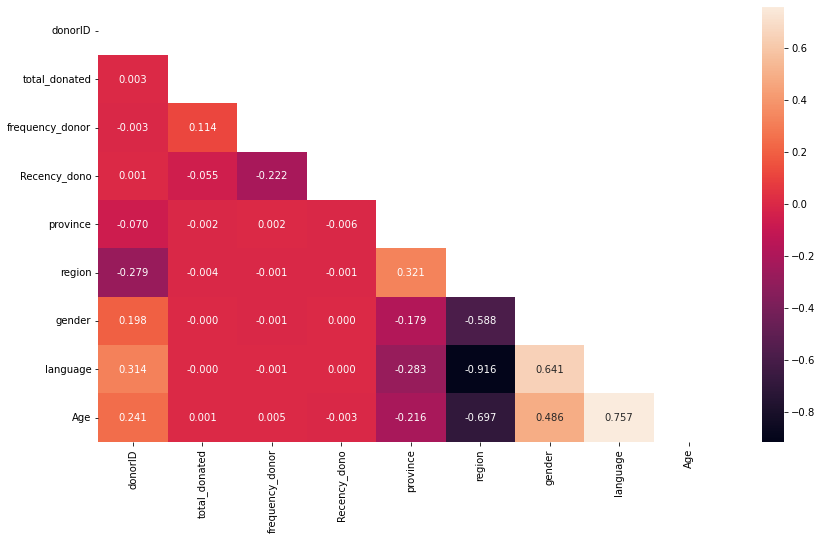

In [205]:
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap
fig = plt.figure(figsize=(14,8))
sns.heatmap(corr, annot = True,  fmt='.3f', mask = mask)
plt.show()


In [206]:
## Instantiate a lasso regressor: lasso with normalize
lasso_norm = Lasso(alpha=0.2)

# Fit the regressor to the data
lasso_norm.fit(X,y)

# Compute and print the coefficients
lasso_coef_norm = lasso_norm.fit(X,y).coef_
print(lasso_coef_norm)

[ 1.46456920e-07  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.92796443e-04]


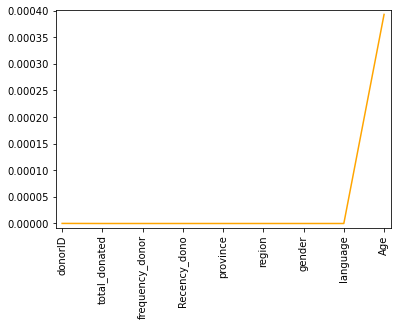

In [207]:
# Plot the coefficients
plt.plot(range(len(X.columns)), lasso_coef_norm,color='orange')
plt.xticks(range(len(X.columns)), X.columns.values, rotation=90)
plt.margins(0.02)
plt.show()

In [208]:
X_end=X.drop(["Recency_dono",'frequency_donor'],axis=1)


Xtrain,Xtest,ytrain,ytest=train_test_split(X_end,y,test_size=0.2,stratify=y,random_state=613)

In [209]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
train_accuracy = np.empty(len(solvers))
test_accuracy = np.empty(len(solvers))

In [210]:
np.random.seed(613)

# Loop over different values of k
for i in range(1,len(solvers)):
    logs=LogisticRegression(solver=solvers[i])

    # Fit the classifier to the training data
    logs.fit(Xtrain,ytrain)

    #Compute accuracy on the training set
  
    train_accuracy[i] = logs.score(Xtrain, ytrain)
    
    #Compute accuracy on the training set
    test_accuracy[i] = logs.score(Xtest,ytest)

C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



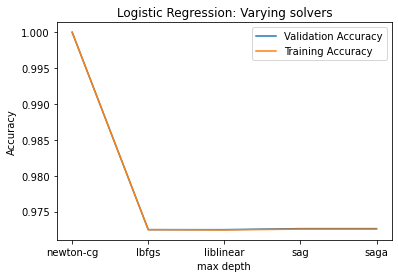

In [211]:
plt.title('Logistic Regression: Varying solvers')
plt.plot(solvers, test_accuracy, label = 'Validation Accuracy')
plt.plot(solvers, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.show()

In [212]:
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
predict_test=lr.predict(Xtest)
predict_train=lr.predict(Xtrain)
acc_train = accuracy_score(ytrain, np.round(predict_train))
acc_test = accuracy_score(ytest, np.round(predict_test))

print(f"Train:\tACC={acc_train:.4f}")
print(f"Test:\tACC={acc_test:.4f}")

Train:	ACC=0.9725
Test:	ACC=0.9725


In [213]:
print(classification_report(ytest, predict_test))
scores = cross_val_score(lr, X, y, cv=5)
scores

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      6787
           1       0.00      0.00      0.00       191

    accuracy                           0.97      6978
   macro avg       0.49      0.50      0.49      6978
weighted avg       0.95      0.97      0.96      6978



array([0.97234165, 0.97219834, 0.97248495, 0.97248101, 0.97248101])

In [214]:
y_pred_prob = lr.predict_proba(Xtest)[:,1]
fpr,tpr,thresholds=roc_curve(ytest,y_pred_prob)
lr.coef_

array([[-3.14365625e-05, -5.25723084e-04, -1.96820354e-04,
        -1.70924521e-04,  2.47014515e-03,  2.54422900e-03,
         4.45077126e-03]])

C:\Users\irana\AppData\Local\Temp/ipykernel_17824/3583084210.py:1: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



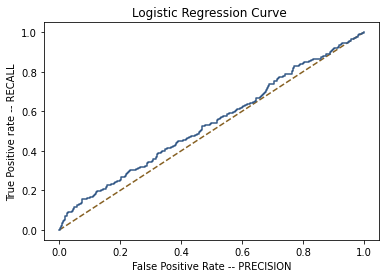

In [215]:
plt.plot([0,1],[0,1],'k--', color="#876123")
plt.plot(fpr,tpr,color='#345987')
plt.xlabel("False Positive Rate -- PRECISION")
plt.ylabel("True Positive rate -- RECALL")
plt.title("Logistic Regression Curve ")
plt.show()

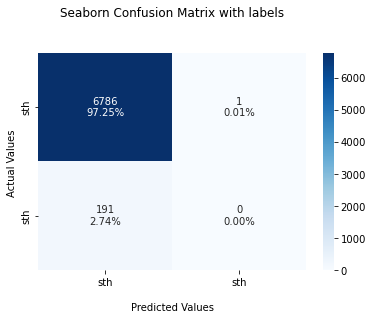

In [216]:
### Source: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

#Generate the confusion matrix

cf_matrix = confusion_matrix(ytest, np.round(y_pred_prob))

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

# Plot correlation Matrix
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['sth','sth'])
ax.yaxis.set_ticklabels(['sth','sth'])



## Display the visualization of the Confusion Matrix.
plt.show()

In [217]:
rfs = np.arange(1, 11)
train_accuracy = np.empty(len(rfs))
test_accuracy = np.empty(len(rfs))

In [218]:
# Loop over different values 
for i in range (0,10):
    # Setup a RF Classifier 
    rfss=RandomForestClassifier(n_estimators=100, max_depth=i+1, random_state=42)

    # Fit the classifier to the training data
    rfss.fit(Xtrain,ytrain)
    predicted_train = rfss.predict(Xtrain)
    predicted_test = rfss.predict(Xtest)

    test_accuracy[i] = accuracy_score(ytest, predicted_test)
    
    #Compute accuracy on the training set
    train_accuracy[i] = accuracy_score(ytrain,predicted_train)

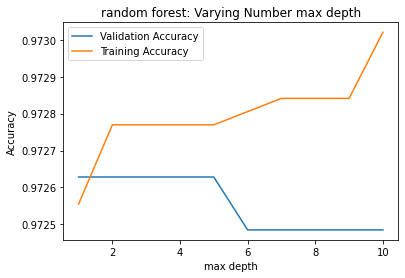

In [219]:
plt.title('random forest: Varying Number max depth')
plt.plot(rfs, test_accuracy, label = 'Validation Accuracy')
plt.plot(rfs, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.show()

C:\Users\irana\AppData\Local\Temp/ipykernel_17824/3554226799.py:11: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



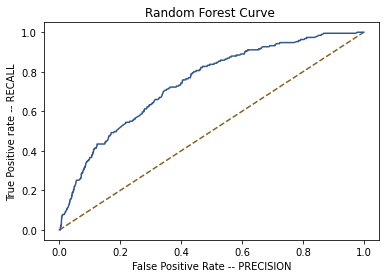

In [220]:
rf=RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

rf = rf.fit(Xtrain,ytrain)

# Predict on the validation set
y_pred_prob = rf.predict_proba(Xtest)[:,1]

# Construct ROC 
fpr,tpr,thresholds=roc_curve(ytest,y_pred_prob)

plt.plot([0,1],[0,1],'k--', color="#876123")
plt.plot(fpr,tpr,color='#345987')
plt.xlabel("False Positive Rate -- PRECISION")
plt.ylabel("True Positive rate -- RECALL")
plt.title("Random Forest Curve ")
plt.show()

In [221]:
import h2o
from h2o.automl import H2OAutoML
#from autosklearn.classification import AutoSklearnClassifier

In [38]:
h2o.init(nthreads = -1,max_mem_size_GB = 2)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 15+36-1562, mixed mode, sharing)
  Starting server from C:\tools\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\irana\AppData\Local\Temp\tmp1e84ku5a
  JVM stdout: C:\Users\irana\AppData\Local\Temp\tmp1e84ku5a\h2o_irana_started_from_python.out
  JVM stderr: C:\Users\irana\AppData\Local\Temp\tmp1e84ku5a\h2o_irana_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 27 days
H2O_cluster_name:,H2O_from_python_irana_g67n5u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [222]:
h_df =  h2o.H2OFrame(gifts_6169)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [223]:
h_df

donorID,total_donated,frequency_donor,last_date_dono,Recency_dono,province,region,gender,language,Age,donated_more_than30_duringdv
100001,31.7784,1,2018-06-21 00:00:00,51.2194,3,1,1,1,50,0
100002,31.7784,1,2018-06-21 00:00:00,51.2194,0,1,0,1,66,0
100004,31.7784,1,2018-06-21 00:00:00,51.2194,1,0,1,2,66,0
100008,31.7784,1,2018-06-21 00:00:00,51.2194,3,1,0,2,81,0
100009,31.7784,1,2018-06-21 00:00:00,51.2194,1,0,0,2,86,0
100010,31.7784,1,2018-06-21 00:00:00,51.2194,1,0,0,2,35,0
100011,31.7784,1,2018-06-21 00:00:00,51.2194,1,0,0,1,55,0
100012,31.7784,1,2018-06-21 00:00:00,51.2194,1,0,1,2,41,0
100013,31.7784,1,2018-06-21 00:00:00,51.2194,1,0,1,2,44,0
100014,31.7784,1,2018-06-21 00:00:00,51.2194,0,1,0,1,32,0


In [86]:
train, test =h_df.split_frame(ratios=[0.8], seed = 1)

In [87]:
y = "donated_more_than30_duringdv"

In [88]:
aml = H2OAutoML(max_models=10, balance_classes=True, seed=1)
aml.train(training_frame=train, y=y)

AutoML progress: |
16:18:39.3: AutoML: XGBoost is not available; skipping it.
16:18:39.3: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
16:18:39.3: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

██████████
16:18:57.306: XRT_1_AutoML_2_20211204_161839 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError

███
16:19:00.334: DeepLearning_1_AutoML_2_20211204_161839 [DeepLearning def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DeepLearning model: DeepLearning_1_AutoML_2_20211204_161839_cv_1.  Details: ERRR on field: _balance_classes: balance_classes requires classification.


██████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_2_20211204_161839_model_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,28.0,28.0,6744.0,4.0,4.0,4.0,9.0,16.0,14.571428




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.025750545514863273
RMSE: 0.160469765111261
MAE: 0.05189703227695131
RMSLE: 0.11136022999797515
Mean Residual Deviance: 0.025750545514863273

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.026157971011297784
RMSE: 0.161734260474699
MAE: 0.05237086657319572
RMSLE: 0.11250533277451541
Mean Residual Deviance: 0.026157971011297784

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.052326,0.001546,0.053337,0.050060,0.051781,0.052362,0.054088
1,mean_residual_deviance,0.026174,0.002160,0.027900,0.022847,0.025395,0.026596,0.028130
2,mse,0.026174,0.002160,0.027900,0.022847,0.025395,0.026596,0.028130
3,r2,0.024085,0.010408,0.024184,0.007164,0.031936,0.023817,0.033321
4,residual_deviance,0.026174,0.002160,0.027900,0.022847,0.025395,0.026596,0.028130
5,rmse,0.161669,0.006770,0.167032,0.151152,0.159358,0.163083,0.167721
6,rmsle,0.112539,0.004345,0.116010,0.105905,0.110777,0.113550,0.116455



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-12-04 16:19:04,1.808 sec,0.0,0.163833,0.053683,0.026841
1,,2021-12-04 16:19:04,1.839 sec,5.0,0.162391,0.052943,0.026371
2,,2021-12-04 16:19:04,1.871 sec,10.0,0.161663,0.052680,0.026135
3,,2021-12-04 16:19:04,1.897 sec,15.0,0.161177,0.052396,0.025978
4,,2021-12-04 16:19:04,1.924 sec,20.0,0.160767,0.052132,0.025846
5,,2021-12-04 16:19:04,1.950 sec,25.0,0.160564,0.051996,0.025781
6,,2021-12-04 16:19:04,1.965 sec,28.0,0.160470,0.051897,0.025751



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Age,74.448700,1.000000,0.469188
1,gender,43.277676,0.581309,0.272743
2,donorID,25.051687,0.336496,0.157880
3,province,7.083640,0.095148,0.044642
4,language,2.795351,0.037547,0.017617
5,Recency_dono,2.592050,0.034817,0.016336
6,total_donated,1.602732,0.021528,0.010101
7,region,1.502521,0.020182,0.009469
8,frequency_donor,0.321268,0.004315,0.002025
9,last_date_dono,0.000000,0.000000,0.000000


In [89]:
#compare the model performance using the leaderboard.
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_1_AutoML_2_20211204_161839_model_2,0.026158,0.161734,0.026158,0.0523709,0.112505
StackedEnsemble_BestOfFamily_4_AutoML_2_20211204_161839,0.0261584,0.161735,0.0261584,0.0523311,0.112549
StackedEnsemble_AllModels_3_AutoML_2_20211204_161839,0.0261627,0.161749,0.0261627,0.0523329,0.112579
StackedEnsemble_BestOfFamily_6_AutoML_2_20211204_161839,0.026165,0.161756,0.026165,0.0524418,0.112451
StackedEnsemble_Best1000_1_AutoML_2_20211204_161839,0.0261681,0.161766,0.0261681,0.052421,0.112647
StackedEnsemble_AllModels_5_AutoML_2_20211204_161839,0.0261693,0.161769,0.0261693,0.0524206,0.112488
GBM_grid_1_AutoML_2_20211204_161839_model_11,0.0262071,0.161886,0.0262071,0.0526639,0.112371
StackedEnsemble_AllModels_2_AutoML_2_20211204_161839,0.0262256,0.161943,0.0262256,0.0525362,0.112723
GBM_grid_1_AutoML_2_20211204_161839_model_9,0.0262464,0.162007,0.0262464,0.0527764,0.112481
StackedEnsemble_BestOfFamily_3_AutoML_2_20211204_161839,0.0262501,0.162019,0.0262501,0.0526072,0.112743


In [90]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_2_20211204_161839_model_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,28.0,28.0,6744.0,4.0,4.0,4.0,9.0,16.0,14.571428




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.025750545514863273
RMSE: 0.160469765111261
MAE: 0.05189703227695131
RMSLE: 0.11136022999797515
Mean Residual Deviance: 0.025750545514863273

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.026157971011297784
RMSE: 0.161734260474699
MAE: 0.05237086657319572
RMSLE: 0.11250533277451541
Mean Residual Deviance: 0.026157971011297784

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.052326,0.001546,0.053337,0.050060,0.051781,0.052362,0.054088
1,mean_residual_deviance,0.026174,0.002160,0.027900,0.022847,0.025395,0.026596,0.028130
2,mse,0.026174,0.002160,0.027900,0.022847,0.025395,0.026596,0.028130
3,r2,0.024085,0.010408,0.024184,0.007164,0.031936,0.023817,0.033321
4,residual_deviance,0.026174,0.002160,0.027900,0.022847,0.025395,0.026596,0.028130
5,rmse,0.161669,0.006770,0.167032,0.151152,0.159358,0.163083,0.167721
6,rmsle,0.112539,0.004345,0.116010,0.105905,0.110777,0.113550,0.116455



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-12-04 16:19:04,1.808 sec,0.0,0.163833,0.053683,0.026841
1,,2021-12-04 16:19:04,1.839 sec,5.0,0.162391,0.052943,0.026371
2,,2021-12-04 16:19:04,1.871 sec,10.0,0.161663,0.052680,0.026135
3,,2021-12-04 16:19:04,1.897 sec,15.0,0.161177,0.052396,0.025978
4,,2021-12-04 16:19:04,1.924 sec,20.0,0.160767,0.052132,0.025846
5,,2021-12-04 16:19:04,1.950 sec,25.0,0.160564,0.051996,0.025781
6,,2021-12-04 16:19:04,1.965 sec,28.0,0.160470,0.051897,0.025751



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Age,74.448700,1.000000,0.469188
1,gender,43.277676,0.581309,0.272743
2,donorID,25.051687,0.336496,0.157880
3,province,7.083640,0.095148,0.044642
4,language,2.795351,0.037547,0.017617
5,Recency_dono,2.592050,0.034817,0.016336
6,total_donated,1.602732,0.021528,0.010101
7,region,1.502521,0.020182,0.009469
8,frequency_donor,0.321268,0.004315,0.002025
9,last_date_dono,0.000000,0.000000,0.000000


In [94]:
aml.get_best_model()

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_2_20211204_161839_model_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,28.0,28.0,6744.0,4.0,4.0,4.0,9.0,16.0,14.571428




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.025750545514863273
RMSE: 0.160469765111261
MAE: 0.05189703227695131
RMSLE: 0.11136022999797515
Mean Residual Deviance: 0.025750545514863273

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.026157971011297784
RMSE: 0.161734260474699
MAE: 0.05237086657319572
RMSLE: 0.11250533277451541
Mean Residual Deviance: 0.026157971011297784

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.052326,0.001546,0.053337,0.050060,0.051781,0.052362,0.054088
1,mean_residual_deviance,0.026174,0.002160,0.027900,0.022847,0.025395,0.026596,0.028130
2,mse,0.026174,0.002160,0.027900,0.022847,0.025395,0.026596,0.028130
3,r2,0.024085,0.010408,0.024184,0.007164,0.031936,0.023817,0.033321
4,residual_deviance,0.026174,0.002160,0.027900,0.022847,0.025395,0.026596,0.028130
5,rmse,0.161669,0.006770,0.167032,0.151152,0.159358,0.163083,0.167721
6,rmsle,0.112539,0.004345,0.116010,0.105905,0.110777,0.113550,0.116455



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-12-04 16:19:04,1.808 sec,0.0,0.163833,0.053683,0.026841
1,,2021-12-04 16:19:04,1.839 sec,5.0,0.162391,0.052943,0.026371
2,,2021-12-04 16:19:04,1.871 sec,10.0,0.161663,0.052680,0.026135
3,,2021-12-04 16:19:04,1.897 sec,15.0,0.161177,0.052396,0.025978
4,,2021-12-04 16:19:04,1.924 sec,20.0,0.160767,0.052132,0.025846
5,,2021-12-04 16:19:04,1.950 sec,25.0,0.160564,0.051996,0.025781
6,,2021-12-04 16:19:04,1.965 sec,28.0,0.160470,0.051897,0.025751



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Age,74.448700,1.000000,0.469188
1,gender,43.277676,0.581309,0.272743
2,donorID,25.051687,0.336496,0.157880
3,province,7.083640,0.095148,0.044642
4,language,2.795351,0.037547,0.017617
5,Recency_dono,2.592050,0.034817,0.016336
6,total_donated,1.602732,0.021528,0.010101
7,region,1.502521,0.020182,0.009469
8,frequency_donor,0.321268,0.004315,0.002025
9,last_date_dono,0.000000,0.000000,0.000000


In [178]:
x_cols = ["donorID",	"total_donated",	"frequency_donor",	"last_date_dono",	"Recency_dono",	"province",	"region",	"gender",	"language",	"Age"]
y_col = "donated_more_than30_duringdv"

In [227]:
gifts_6169[x_cols].dtypes

donorID                     int64
total_donated             float64
frequency_donor           float64
last_date_dono     datetime64[ns]
Recency_dono              float64
province                     int8
region                       int8
gender                      int64
language                    int64
Age                       float64
dtype: object

In [95]:
from sklearn.ensemble import GradientBoostingClassifier

In [129]:
gb = GradientBoostingClassifier(loss="exponential", learning_rate=0.1, n_estimators=100)

In [254]:
gb.fit(Xtrain, ytrain)

GradientBoostingClassifier(loss='exponential')

In [255]:
gb_predictions_train = gb.predict(Xtrain)
gb_predictions_test = gb.predict(Xtest)

In [256]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

n_scores = cross_val_score(gb, Xtest, ytest, scoring='accuracy', cv=cv, n_jobs=-1)


In [257]:
n_scores

array([0.97277937, 0.97277937, 0.97277937, 0.97277937, 0.97277937,
       0.97277937, 0.97277937, 0.9713467 , 0.97274032, 0.97274032,
       0.97277937, 0.97277937, 0.97277937, 0.97277937, 0.97277937,
       0.97277937, 0.97277937, 0.9713467 , 0.97274032, 0.97274032,
       0.97277937, 0.97277937, 0.97277937, 0.97277937, 0.97277937,
       0.97277937, 0.97277937, 0.9713467 , 0.97274032, 0.97274032])

In [258]:
acc_train = accuracy_score(ytrain, np.round(gb_predictions_train))
acc_test = accuracy_score(ytest, np.round(gb_predictions_test))

print(f"Train:\tACC={acc_train:.4f}")
print(f"Test:\tACC={acc_test:.4f}")

Train:	ACC=0.9728
Test:	ACC=0.9726


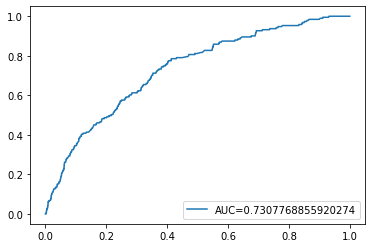

In [260]:
from sklearn import metrics

y_pred_proba = gb.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()


In [261]:
from sklearn.metrics import roc_curve, auc

In [281]:
# The histogram of scores compared to true labels
fpr, tpr, thresholds = roc_curve(ytest,  y_pred_proba)
fig_hist = px.histogram(
    x=y_pred_proba, color=ytest, nbins=20,
    labels=dict(color='True Labels', x='Score')
)
fig.update_layout(barmode='overlay')

fig.update_traces(opacity=0.75)

fig_hist.show()


In [164]:
# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

In [165]:
#Plot ROC AUC Curve 
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [168]:
X_7244 = gifts_7244.drop("donated_more_than30_duringdv", axis=1)
y_7244 = gifts_7244["donated_more_than30_duringdv"]

In [172]:
X_7244.columns

Index(['donorID', 'total_donated', 'frequency_donor', 'last_date_dono',
       'Recency_dono', 'province', 'region', 'gender', 'language', 'Age'],
      dtype='object')

In [233]:
len(Xtrain.columns)

7

In [234]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

tf.random.set_seed(123)

model = keras.Sequential([
    keras.layers.Dense(7, input_shape=(7,), activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )
])

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [235]:
model.fit(Xtrain, ytrain, workers=6, shuffle=2, epochs=500)

Epoch 1/500
873/873 [==============================] - 2s 1ms/step - loss: 1061.4948 - accuracy: 0.8404
Epoch 2/500
873/873 [==============================] - 1s 1ms/step - loss: 2.9799 - accuracy: 0.9454
Epoch 3/500
873/873 [==============================] - 1s 996us/step - loss: 4.4827 - accuracy: 0.9471
Epoch 4/500
873/873 [==============================] - 1s 891us/step - loss: 5.0172 - accuracy: 0.9452
Epoch 5/500
873/873 [==============================] - 1s 911us/step - loss: 5.3323 - accuracy: 0.9459
Epoch 6/500
873/873 [==============================] - 1s 900us/step - loss: 4.9933 - accuracy: 0.9457
Epoch 7/500
873/873 [==============================] - 1s 836us/step - loss: 4.9544 - accuracy: 0.9473
Epoch 8/500
873/873 [==============================] - 1s 948us/step - loss: 5.0434 - accuracy: 0.9449
Epoch 9/500
873/873 [==============================] - 1s 966us/step - loss: 4.0338 - accuracy: 0.9482
Epoch 10/500
873/873 [==============================] - 1s 985us/step - lo

In [240]:
yp = model.predict(Xtest)

y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [241]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      6787
           1       0.00      0.00      0.00       191

    accuracy                           0.97      6978
   macro avg       0.49      0.50      0.49      6978
weighted avg       0.95      0.97      0.96      6978



C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Text(69.0, 0.5, 'Truth')

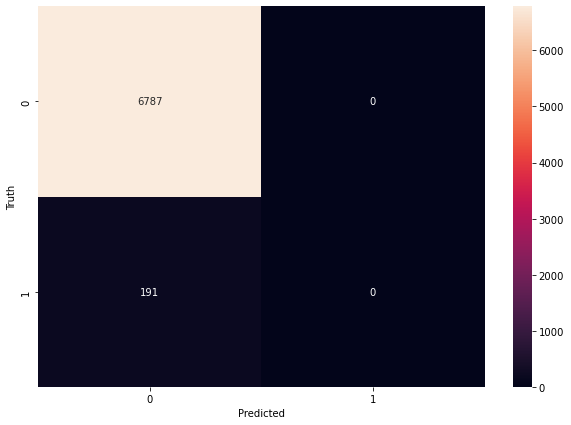

In [242]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=ytest,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [243]:
fpr, tpr, thresholds = roc_curve(ytest,  y_pred)
#Plot ROC AUC Curve 
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [288]:
X = gifts_7244[x_cols]
Y = gifts_7244[y_col]



In [289]:
import datetime as dt
X["last_date_dono"] = X["last_date_dono"].map(dt.datetime.toordinal)

C:\Users\irana\AppData\Local\Temp/ipykernel_17824/2495992863.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [290]:
X.dtypes

donorID              int64
total_donated      float64
frequency_donor    float64
last_date_dono       int64
Recency_dono       float64
province              int8
region                int8
gender               int64
language             int64
Age                  int64
dtype: object

In [300]:
gifts_6169["last_date_dono"] = gifts_6169["last_date_dono"].map(dt.datetime.toordinal)
gifts_7244["last_date_dono"] = gifts_7244["last_date_dono"].map(dt.datetime.toordinal)

In [297]:
gb.fit(gifts_6169[x_cols], gifts_6169[y_col])

GradientBoostingClassifier(loss='exponential')

In [302]:
predict_7244 = gb.predict(gifts_7244[x_cols])

In [303]:
fpr, tpr, thresholds = roc_curve(gifts_7244[y_col],  predict_7244)
#Plot ROC AUC Curve 
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()